In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
import numpy as np
from LinearMPC_3_2.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
# 1. Setup Parameters
Ts = 0.05           # Sampling time (Fixed)
sim_time = 10.0     # Simulation time (7s is the requirement, 10s is safe to view stability)
H = 5.0             # Prediction Horizon in Seconds

# 2.1 Define Initial State
# State vector: [wx, wy, wz, alpha, beta, gamma, vx, vy, vz, x, y, z]
x0 = np.zeros(12)

# 2.2 Define Target State
x_target = np.zeros(12)
x_target[5] = np.deg2rad(35)  # Target Roll angle (gamma)
x_target[6:9] = np.array([3.0] * 3)  # Target velocity (vx, vy, vz)

# 3. Initialize Rocket and Controller
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# 4. Simulate Closed-Loop Control
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method="linear"
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Maximum invariant set successfully computed after 6 iterations:
  Dimension: 3
Maximum invariant set successfully computed after 6 iterations:
  Dimension: 3
Maximum invariant set successfully computed after 1 iterations:
  Dimension: 1
Maximum invariant set successfully computed after 34 iterations:
  Dimension: 2
Simulating time 0.00: 

c:\Users\tancr\miniconda3\envs\mpc2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulating time 0.25: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulating time 0.30: 
Simulating time 0.35: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulating time 0.40: 
Simulating time 0.45: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulating time 0.50: 
Simulating time 0.55: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
 State alpha violation: -0.17 < -0.17, 
 State beta violation: 0.17 > 0.17, 
Simulati

In [4]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

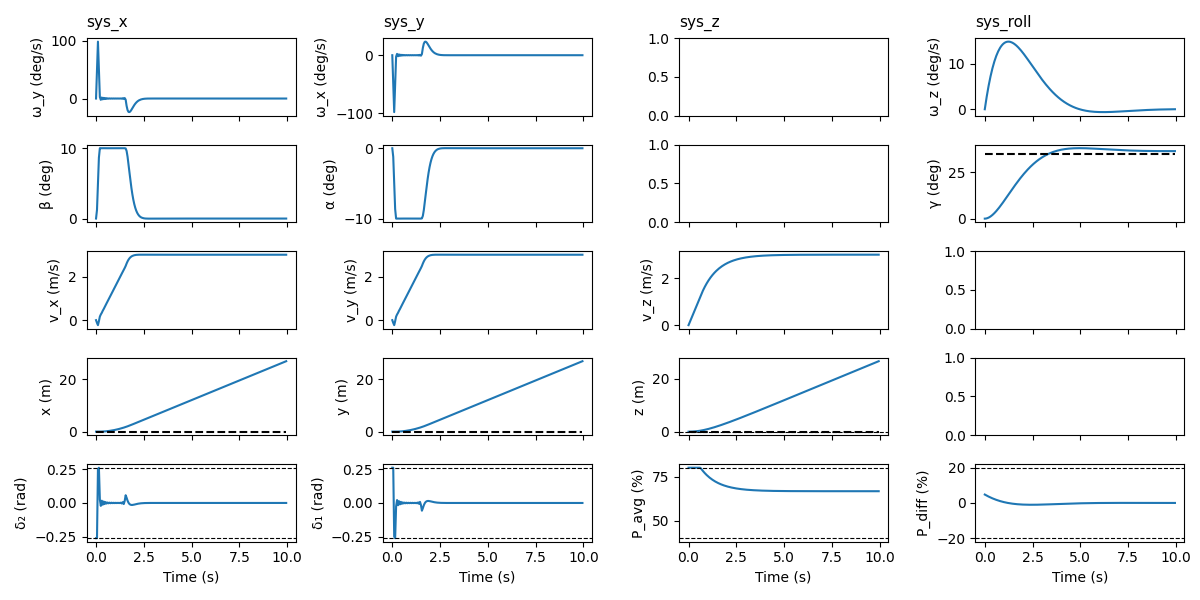

In [5]:
from src.vel_rocket_vis import plot_static_states_inputs
# Closed-loop states and inputs
plot_static_states_inputs(t_cl[:-1], x_cl[:, :-1], u_cl, Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1))

In [11]:
x_target.reshape(-1, 1)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.61086524],
       [3.        ],
       [3.        ],
       [3.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

### Visualize Terminal Invariant Sets of the 4 Subsystems

In [6]:
mpc.mpc_roll.X_f.dim, mpc.mpc_x.X_f.dim, mpc.mpc_y.X_f.dim, mpc.mpc_z.X_f.dim

(2, 3, 3, 1)

#### Roll Subsystem

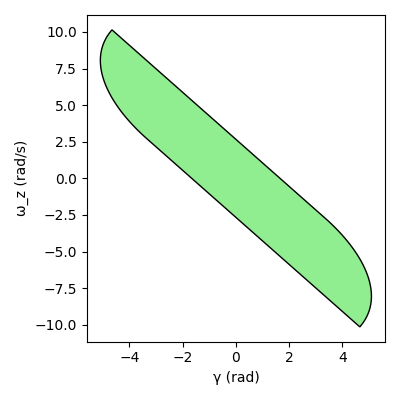

In [7]:
import matplotlib.pyplot as plt

# Roll Subsystem has 2D terminal invariant set so this is easy to plot
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel("γ (rad)")
ax.set_ylabel("ω_z (rad/s)")
mpc.mpc_roll.X_f.plot(ax, color="lightgreen")
plt.tight_layout()
plt.show()

#### X Subsystem

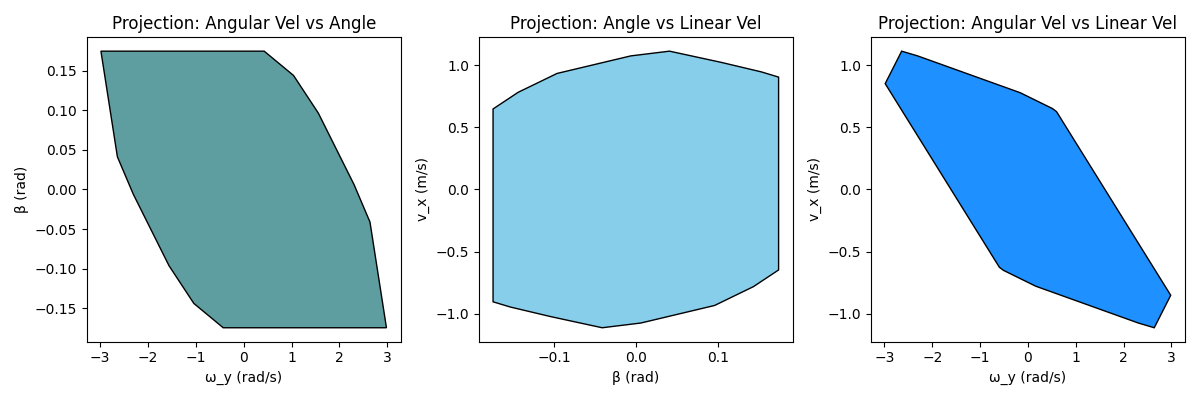

In [8]:
import matplotlib.pyplot as plt

# X Subsytem has 3 dimensions: wy, beta, vx
# So we plot all 3 2D projections

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 1. Plot Omega_y (0) vs Beta (1)
# We project onto dimensions 0 and 1
Xf_01 = mpc.mpc_x.X_f.projection(dims=(0, 1))
Xf_01.plot(axs[0], color='cadetblue')
axs[0].set_xlabel("ω_y (rad/s)")
axs[0].set_ylabel("β (rad)")
axs[0].set_title("Projection: Angular Vel vs Angle")

# 2. Plot Beta (1) vs Velocity X (2)
# We project onto dimensions 1 and 2
Xf_12 = mpc.mpc_x.X_f.projection(dims=(1, 2))
Xf_12.plot(axs[1], color='skyblue')
axs[1].set_xlabel("β (rad)")
axs[1].set_ylabel("v_x (m/s)")
axs[1].set_title("Projection: Angle vs Linear Vel")

# 3. Plot Omega_y (0) vs Velocity X (2)
# We project onto dimensions 0 and 2
Xf_02 = mpc.mpc_x.X_f.projection(dims=(0, 2))
Xf_02.plot(axs[2], color='dodgerblue')
axs[2].set_xlabel("ω_y (rad/s)")
axs[2].set_ylabel("v_x (m/s)")
axs[2].set_title("Projection: Angular Vel vs Linear Vel")

plt.tight_layout()
plt.show()


#### Y Subsystem

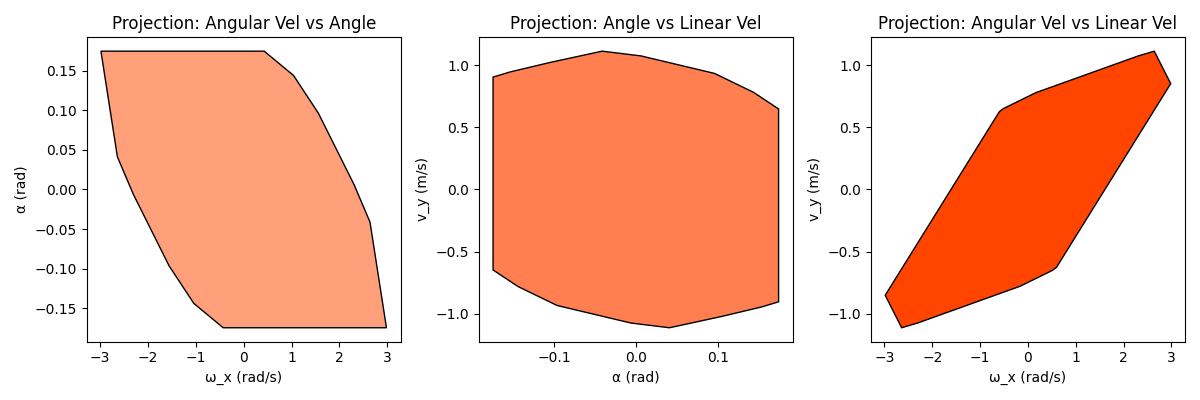

In [9]:
# Same as X Subsystem but for Y Subsystem

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 1. Plot Omega_x (0) vs Alpha (1)
# We project onto dimensions 0 and 1
Xf_01 = mpc.mpc_y.X_f.projection(dims=(0, 1))
Xf_01.plot(axs[0], color='lightsalmon')
axs[0].set_xlabel("ω_x (rad/s)")
axs[0].set_ylabel("α (rad)")
axs[0].set_title("Projection: Angular Vel vs Angle")
# 2. Plot Alpha (1) vs Velocity Y (2)
# We project onto dimensions 1 and 2
Xf_12 = mpc.mpc_y.X_f.projection(dims=(1, 2))
Xf_12.plot(axs[1], color='coral')
axs[1].set_xlabel("α (rad)")
axs[1].set_ylabel("v_y (m/s)")
axs[1].set_title("Projection: Angle vs Linear Vel")
# 3. Plot Omega_x (0) vs Velocity Y (2)
# We project onto dimensions 0 and 2
Xf_02 = mpc.mpc_y.X_f.projection(dims=(0, 2))
Xf_02.plot(axs[2], color='orangered')
axs[2].set_xlabel("ω_x (rad/s)")
axs[2].set_ylabel("v_y (m/s)")
axs[2].set_title("Projection: Angular Vel vs Linear Vel")

plt.tight_layout()
plt.show()

#### Z Subsystem

In [10]:
# This one is 1 dimensional so not even plotable in 2D
# Let's just print the limits
v = mpc.mpc_z.X_f.V.flatten()
print(f"Z Subsystem Terminal Invariant Set Limits: [{v.min():.4f}, {v.max():.4f}]")

Z Subsystem Terminal Invariant Set Limits: [-1.7711, 3.5421]
